# kernex

In [1]:
import jax
import jax.numpy as jnp
import kernex as kex
import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

In [3]:
@kex.kmap(kernel_size=(3,))
def sum_all(x):
    return jnp.sum(x)

In [4]:
x = jnp.array([1, 2, 3, 4, 5])

In [5]:
print(sum_all(x))

[ 6  9 12]


In [6]:
@kex.kscan(kernel_size=(3,))
def sum_all(x):
    return jnp.sum(x)

In [7]:
x = jnp.array([1, 2, 3, 4, 5])

In [8]:
print(sum_all(x))

[ 6 13 22]


In [9]:
@jax.jit
@kex.kmap(kernel_size=(3, 3, 3), padding=("valid", "same", "same"))
def kernex_conv2d(x, w):
    # JAX channel first conv2d with 3x3x3 kernel_size
    return jnp.sum(x * w)

In [10]:
@kex.kmap(
    kernel_size=(3, 3), padding="valid", relative=True
)  # `relative`= True enables relative indexing
def laplacian(x):
    return (
        0 * x[1, -1]
        + 1 * x[1, 0]
        + 0 * x[1, 1]
        + 1 * x[0, -1]
        + -4 * x[0, 0]
        + 1 * x[0, 1]
        + 0 * x[-1, -1]
        + 1 * x[-1, 0]
        + 0 * x[-1, 1]
    )

In [11]:
print(laplacian(jnp.ones([10, 10])))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
@kex.kmap(kernel_size=(3, 3), relative=True)
def identity(x):
    return x[0, 0]

In [13]:
@jax.jit
@kex.kmap(kernel_size=(3, 3), padding="same")
def get_3x3_patches(x):
    # returns 5x5x3x3 array
    return x

In [14]:
mat = jnp.arange(1, 26).reshape(5, 5)

In [15]:
print(mat)

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]]


In [16]:
print(get_3x3_patches(mat)[0, 0])

[[0 0 0]
 [0 1 2]
 [0 6 7]]


In [17]:
# # see https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/01_Step_1.ipynb
# tmax,xmax = 0.5,2.0
# nt,nx = 151,51
# dt,dx = tmax/(nt-1) , xmax/(nx-1)
# u = jnp.ones([nt,nx])
# c = 0.5

In [18]:
# # kscan moves sequentially in row-major order and updates in-place using lax.scan.
# F = kernex.kscan(
#         kernel_size = (3,3),
#         padding = ((1,1),(1,1)),
#         # n for time axis , i for spatial axis (optional naming)
#         named_axis={0:'n',1:'i'},
#         relative=True
#     )

In [19]:
# # boundary condtion as a function
# def bc(u):
#     return 1

# # initial condtion as a function
# def ic1(u):
#     return 1

# def ic2(u):
#     return 2

# def linear_convection(u):
#     return ( u['i','n-1'] - (c*dt/dx) * (u['i','n-1'] - u['i-1','n-1']) )

In [20]:
# F[:,0]  = F[:,-1] = bc # assign 1 for left and right boundary for all t

# # square wave initial condition
# F[:,:int((nx-1)/4)+1] = F[:,int((nx-1)/2):] = ic1
# F[0:1, int((nx-1)/4)+1 : int((nx-1)/2)] = ic2

# # assign linear convection function for
# # interior spatial location [1:-1]
# # and start from t>0  [1:]
# F[1:,1:-1] = linear_convection

In [21]:
# kx_solution = F(jnp.array(u))

In [22]:
# plt.figure(figsize=(20,7))
# for line in kx_solution[::20]:
#     plt.plot(jnp.linspace(0,xmax,nx),line)

In [23]:
def gaussian_blur(image, sigma, kernel_size):
    x = jnp.linspace(-(kernel_size - 1) / 2.0, (kernel_size - 1) / 2.0, kernel_size)
    w = jnp.exp(-0.5 * jnp.square(x) * jax.lax.rsqrt(sigma))
    w = jnp.outer(w, w)
    w = w / w.sum()

    @kex.kmap(kernel_size=(kernel_size, kernel_size), padding="same")
    def conv(x):
        return jnp.sum(x * w)

    return conv(image)

In [24]:
@jax.jit
@jax.vmap
@kex.kmap(kernel_size=(3, 3), padding=("same", "same"))
def kernex_depthwise_conv2d(x, w):
    return jnp.sum(x * w)

In [25]:
h, w, c = 5, 5, 2
k = 3

In [26]:
x = jnp.arange(1, h * w * c + 1).reshape(c, h, w)
w = jnp.arange(1, k * k * c + 1).reshape(c, k, k)

In [27]:
print(kernex_depthwise_conv2d(x, w))

[[[ 128  202  241  280  184]
  [ 276  411  456  501  318]
  [ 441  636  681  726  453]
  [ 606  861  906  951  588]
  [ 320  436  457  478  280]]

 [[1872 2770 2863 2956 1936]
  [2802 4128 4254 4380 2856]
  [3237 4758 4884 5010 3261]
  [3672 5388 5514 5640 3666]
  [2304 3364 3439 3514 2272]]]


In [28]:
@jax.vmap  # vectorize over the channel dimension
@kex.kmap(kernel_size=(3, 3), strides=(2, 2))
def avgpool_2d(x):
    # define the kernel for the Average pool operation over the spatial dimensions
    return jnp.mean(x)

In [29]:
# lets solve dydt = y, where y0 = 1 and y(t)=e^t
# using Runge-Kutta 4th order method
# f(t,y) = y


t = jnp.linspace(0, 1, 5)
y = jnp.zeros(5)
x = jnp.stack([y, t], axis=0)
dt = t[1] - t[0]  # 0.1
f = lambda tn, yn: yn

In [30]:
def ic(x):
    """initial condition y0 = 1"""
    return 1.0


def rk4(x):
    """runge kutta 4th order integration step"""
    # ┌────┬────┬────┐      ┌──────┬──────┬──────┐
    # │ y0 │*y1*│ y2 │      │[0,-1]│[0, 0]│[0, 1]│
    # ├────┼────┼────┤ ==>  ├──────┼──────┼──────┤
    # │ t0 │ t1 │ t2 │      │[1,-1]│[1, 0]│[1, 1]│
    # └────┴────┴────┘      └──────┴──────┴──────┘
    t0 = x[1, -1]
    y0 = x[0, -1]
    k1 = dt * f(t0, y0)
    k2 = dt * f(t0 + dt / 2, y0 + 1 / 2 * k1)
    k3 = dt * f(t0 + dt / 2, y0 + 1 / 2 * k2)
    k4 = dt * f(t0 + dt, y0 + k3)
    yn_1 = y0 + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return yn_1

In [31]:
F = kex.kscan(kernel_size=(2, 3), relative=True, padding=((0, 1)))  # kernel size = 3

F[0:1, 1:] = rk4
F[0, 0] = ic

In [32]:
# compile the solver
solver = jax.jit(F.__call__)
y = solver(x)[0, :]

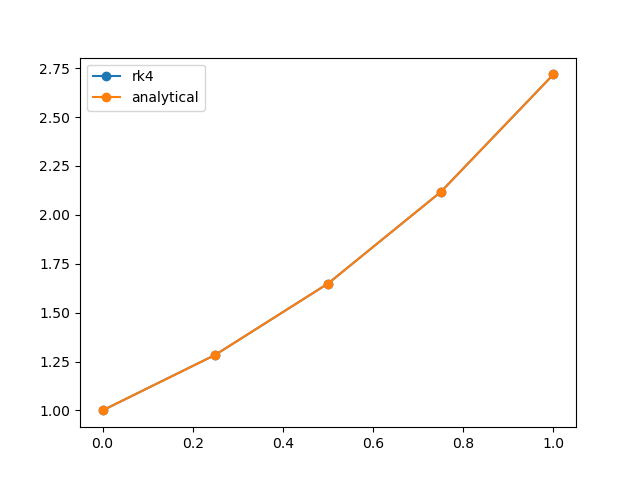

In [33]:
plt.plot(t, y, "-o", label="rk4")
plt.plot(t, jnp.exp(t), "-o", label="analytical")
plt.legend()
plt.show()